In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore, f_oneway, ttest_ind
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from ds_functions import *

## Data Cleaning

In [65]:
suicides = pd.read_csv('suicides.csv')

### Preview Dataset

In [51]:
suicides.head()

,IndicatorCode,Indicator,ValueType,ParentLocationCode,ParentLocation,Location type,SpatialDimValueCode,Location,Period type,Period,...,Dim1 type,Dim1,Dim1ValueCode,Dim2 type,Dim2,Dim2ValueCode,FactValueNumeric,Value,Language,DateModified
0,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,15-24 years,15-24,0.0,0.0,EN,2021-07-06T04:00:00.000Z
1,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,25-34 years of age,25-34,0.0,0.0,EN,2021-07-06T04:00:00.000Z
2,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,35-44 years of age,35-44,0.0,0.0,EN,2021-07-06T04:00:00.000Z
3,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,45-54 years,45-54,0.0,0.0,EN,2021-07-06T04:00:00.000Z
4,SDGSUICIDE,Crude suicide rates (per 100 000 population),text,AMR,Americas,Country,ATG,Antigua and Barbuda,Year,2019,...,Sex,Both sexes,BTSX,Age Group,65-74 years,65-74,0.0,0.0,EN,2021-07-06T04:00:00.000Z


In [50]:
# Check columns to identify which columns to drop that contain missing data over 60%
missing_data_check(suicides)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4392 entries, 0 to 4391
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   IndicatorCode        4392 non-null   object 
 1   Indicator            4392 non-null   object 
 2   ValueType            4392 non-null   object 
 3   ParentLocationCode   4392 non-null   object 
 4   ParentLocation       4392 non-null   object 
 5   Location type        4392 non-null   object 
 6   SpatialDimValueCode  4392 non-null   object 
 7   Location             4392 non-null   object 
 8   Period type          4392 non-null   object 
 9   Period               4392 non-null   int64  
 10  IsLatestYear         4392 non-null   bool   
 11  Dim1 type            4392 non-null   object 
 12  Dim1                 4392 non-null   object 
 13  Dim1ValueCode        4392 non-null   object 
 14  Dim2 type            4392 non-null   object 
 15  Dim2                 4392 non-null   o

### Chosing columns for EDA (Metadata)

-- Metadata on columns for Crude Suicide Rates (per 100 000 population)-- <br>
ParentLocation = Region ('Americas', 'Western Pacific', 'Europe', 'Africa', 'South-East Asia', 'Eastern Mediterranean') <br>
Location = Country data surveyed (Multitude) <br>
Value = Crude Suicide Rates (per 100 000 population) <br>
Sex = Gender (Male/Female/Both) <br>
AgeRange = Age ranges for data (Assume 100 yrs old is max)

In [66]:
# Variables to hold column names for future lookups in the dataset
region = 'region'
age_range = 'age_range'
sex = 'sex'
country = 'country'
suicide_rate = 'suicide_rate'

#### Remove metadata columns for future EDA (Exploratory Data Analysis)

In [67]:
# Identify columns to remove to create a clean dataset for EDA
suicide_columns = suicides.columns.to_list()
print(suicide_columns)

#Add desired columns to a list
desired_columns = ['ParentLocation', 'Location', 'Value', 'Dim1', 'Dim2ValueCode']

suicides_clean = suicides[desired_columns].rename(columns={'Dim1': sex, 'Dim2ValueCode': age_range, 'ParentLocation': region, 'Location': country, 'Value': suicide_rate})
suicides_clean.head()

['IndicatorCode', 'Indicator', 'ValueType', 'ParentLocationCode', 'ParentLocation', 'Location type', 'SpatialDimValueCode', 'Location', 'Period type', 'Period', 'IsLatestYear', 'Dim1 type', 'Dim1', 'Dim1ValueCode', 'Dim2 type', 'Dim2', 'Dim2ValueCode', 'Dim3 type', 'Dim3', 'Dim3ValueCode', 'DataSourceDimValueCode', 'DataSource', 'FactValueNumericPrefix', 'FactValueNumeric', 'FactValueUoM', 'FactValueNumericLowPrefix', 'FactValueNumericLow', 'FactValueNumericHighPrefix', 'FactValueNumericHigh', 'Value', 'FactValueTranslationID', 'FactComments', 'Language', 'DateModified']


,region,country,suicide_rate,sex,age_range
0,Americas,Antigua and Barbuda,0.0,Both sexes,YEARS15-24
1,Americas,Antigua and Barbuda,0.0,Both sexes,YEARS25-34
2,Americas,Antigua and Barbuda,0.0,Both sexes,YEARS35-44
3,Americas,Antigua and Barbuda,0.0,Both sexes,YEARS45-54
4,Americas,Antigua and Barbuda,0.0,Both sexes,YEARS65-74


#### Data Column Transformations

In [68]:
#Check values of age_range to determine how to split the strings
suicides_clean[age_range].value_counts()

YEARS15-24     549
YEARS25-34     549
YEARS35-44     549
YEARS45-54     549
YEARS65-74     549
YEARS75-84     549
YEARS85PLUS    549
YEARS55-64     549
Name: age_range, dtype: int64

In [69]:
#Replace YEARS with "" to prep for a column split
suicides_clean[age_range] = suicides_clean[age_range].replace('YEARS', '', regex=True)
print(suicides_clean[age_range].value_counts())

#Check dataframe for accurate split and new columns
suicides_clean.head()

15-24     549
25-34     549
35-44     549
45-54     549
65-74     549
75-84     549
85PLUS    549
55-64     549
Name: age_range, dtype: int64


,region,country,suicide_rate,sex,age_range
0,Americas,Antigua and Barbuda,0.0,Both sexes,15-24
1,Americas,Antigua and Barbuda,0.0,Both sexes,25-34
2,Americas,Antigua and Barbuda,0.0,Both sexes,35-44
3,Americas,Antigua and Barbuda,0.0,Both sexes,45-54
4,Americas,Antigua and Barbuda,0.0,Both sexes,65-74


In [71]:
# Adjust Sex column where Both sexes = Both for simplicity
suicides_clean[sex] = suicides_clean[sex].apply(lambda sex: 'Both' if sex == 'Both sexes' else sex)

# Check for correct changes
suicides_clean[sex].value_counts()

Both      1464
Female    1464
Male      1464
Name: sex, dtype: int64

In [73]:
# Remove the redundant Both category in sexes for future EDA (Compare Male to Female only)
suicides_clean = suicides_clean[suicides_clean[sex] != 'Both']
suicides_clean[sex].value_counts()

Female    1464
Male      1464
Name: sex, dtype: int64

### Check/adjust data types to complete data cleaning

In [74]:
suicides_clean.dtypes

region           object
country          object
suicide_rate    float64
sex              object
age_range        object
dtype: object

## Univariate Data Profiling

Initial summary statistics to get a general picture of the data. <br>
Also to generate questions to answer using the data and for potential model building

#### Mean suicide rates by region

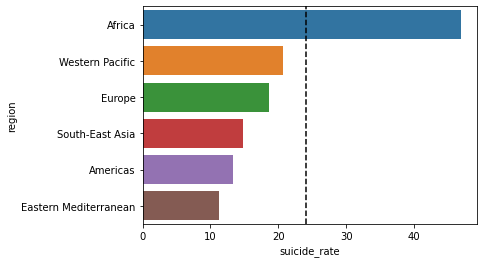

In [75]:
# Visualization of the choosen summary stat to identify trends 
summary_stats_barplot(suicides_clean, np.mean, value=suicide_rate, category=region)

Africa mean suicide rates exceed all other regions and the total average by nearly double or more<br>
Black dashed line is the total suicide_rate mean

#### Median suicide rates by region

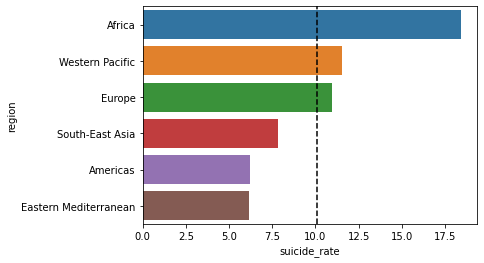

In [76]:
# Visualization of the medians to identify trends
summary_stats_barplot(suicides_clean, np.median, value=suicide_rate, category=region)

Africa median suicide rates exceeds all other regions but not to the extent of the mean suicide rates<br>
Median is more resistant summary statistic to outliers which can explain the differences<br>
Black dashed line is the total median suicide_rate<br>
The presence of outliers will have to be explored with histograms/boxplots

### Distribution of Suicide Rates

<AxesSubplot:xlabel='suicide_rate', ylabel='Count'>

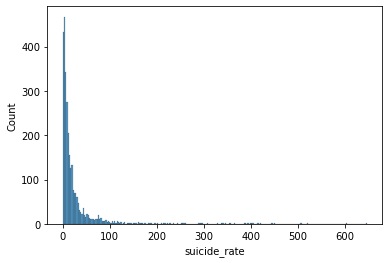

In [77]:
#Histogram to visualize the spread of the suicide rates of all countries together
sns.histplot(data=suicides_clean, x=suicide_rate)

Coarse search reveals right skewed spread due to outliers (All countries) <br>

#### Distribution of Suicide Rates by Region

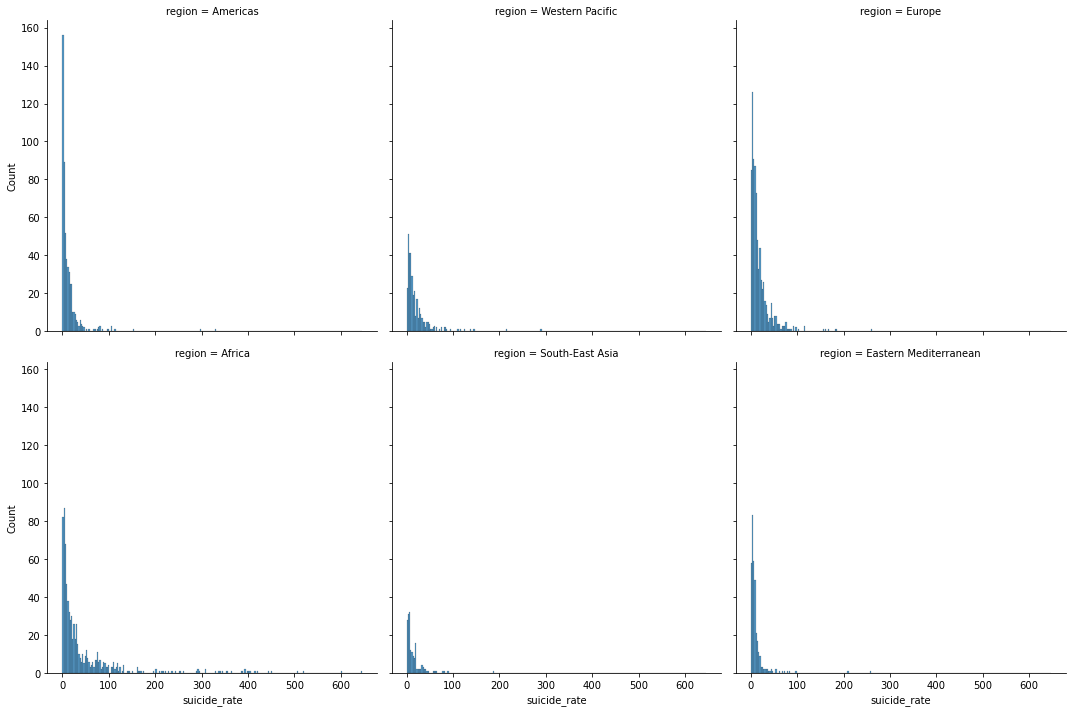

In [78]:
#Figure level plot to aid visualization
sns.displot(data=suicides_clean, x=suicide_rate, col=region, col_wrap=3)

Spread is still right skewed at the region level <br>
An indepth look at the IQR, median and range is needed

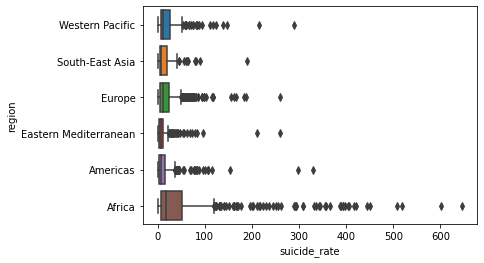

In [79]:
sorted_boxplot(suicides_clean, region, suicide_rate)

Africa appears to have the largest range for suicide rates <br>
The IQR and median is higher than other regions as well

#### Distribution of Suicide Rates by Age Range

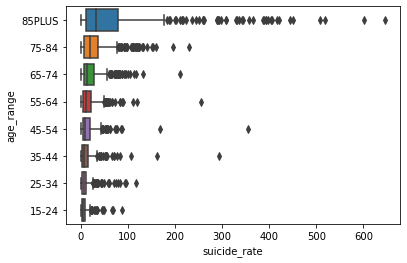

In [80]:
sorted_boxplot(suicides_clean, age_range, suicide_rate)

85Plus age range has the largest range and median<br>
All of the age ranges have a right skewed distribution that will need to be transformed for future EDA

#### Distribution of Suicide Rates by Sex

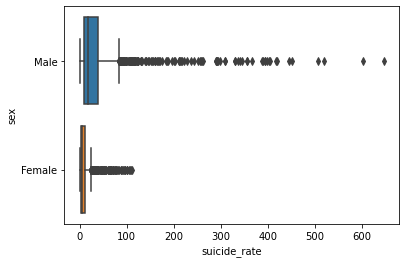

<AxesSubplot:xlabel='suicide_rate', ylabel='Count'>

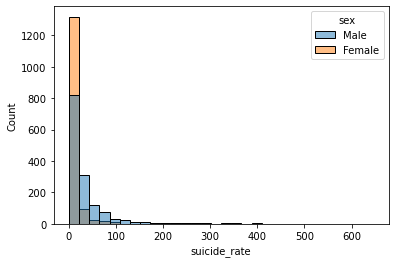

In [82]:
sorted_boxplot(suicides_clean, sex, suicide_rate)

# Histogram to view overlap of suicide rates of males vs females
sns.histplot(data=suicides_clean, x=suicide_rate, hue=sex, bins=30)

Female distribution is concentrated closer to zero<br>
Males have a larger distribution and is skewed more heavily to the right than females

## Are the suicide rates for each region statiscally different?<br>
Null Hypothesis - The suicides rates means do not differ between regions<br>
Alt Hypothesis - Suicide rates are not equal between the regions

### ANOVA Assumptions<br>
--- Taken from codecademy ---<br>
(1) All observations should be independently and randomly sampled<br>
(2) The standard deviations of the groups should be equal<br>
(3) The data should be normally distributed or the sample size should be large<br>
(4) The groups created by the categorical variable should be independent<br>
-------------------------------- <br>
Signifcance Threshold = 0.05

In [83]:
#Calculating std of each region to check if assumption 2 is met (std of groups should be equal)
column_std(suicides_clean, region, suicide_rate)

Eastern Mediterranean 21.408601472135324
Americas 25.816426257329468
Europe 23.758062090561328
Africa 81.8883393890397
Western Pacific 28.426545602541825
South-East Asia 20.39371886463747


Ideal ratio of lowest to highest std is approximately between 0.9 - 1.1<br>
Assumption 3 becomes more lenient as the sample size increases

#### Zscore Normalization
To reduce outlier effects on the standard deviation and distribution of suicide rates for each category

In [84]:
#Use the zscore of the value column to reduce the effects of outliers on assumptions 2 and 3
suicides_zscored = zscore_normalization(suicides_clean, suicide_rate)

53 rows removed


In [85]:
#Checking std difference after zscore to meet ANOVA assumption 2
column_std(suicides_zscored, region, suicide_rate)

Eastern Mediterranean 12.522337104637884
Americas 17.96335675137849
Europe 20.587859783581234
Africa 33.88010175022612
Western Pacific 21.930853317338727
South-East Asia 15.621246053459569


<AxesSubplot:xlabel='suicide_rate', ylabel='region'>

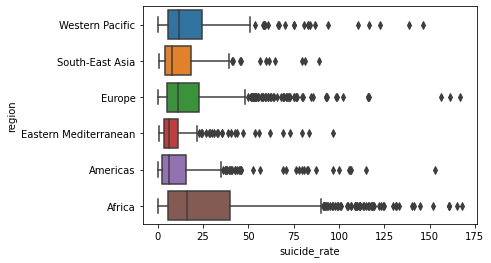

In [88]:
#Visualization of zcored distribution for assumption 3
sns.boxplot(data=suicides_zscored, x=suicide_rate, y=region)

Zscored boxplot of suicide rates  ----<br> 
It's easier to see Africa has a larger median, IQR and range<br>
The Eastern Mediterranean appears to have the lowest suicide rates

#### Zscore normalization ANOVA Test

In [89]:
#Anova test to determine if the pval is significant
anova_test(suicides_zscored, region, suicide_rate)

2.613614708541573e-50


In [90]:
#Tukey's Range Test to determine which pairings are significant
tukeys_test(suicides_zscored, region, suicide_rate)

                Multiple Comparison of Means - Tukey HSD, FWER=0.05                 
        group1                group2        meandiff p-adj   lower    upper   reject
------------------------------------------------------------------------------------
               Africa              Americas -17.4895    0.0 -21.3336 -13.6454   True
               Africa Eastern Mediterranean -19.8074    0.0 -24.2407 -15.3742   True
               Africa                Europe -11.7295    0.0 -15.1781   -8.281   True
               Africa       South-East Asia -15.8946    0.0 -21.5331 -10.2562   True
               Africa       Western Pacific -10.3511    0.0 -14.7844  -5.9179   True
             Americas Eastern Mediterranean  -2.3179 0.7184  -6.9916   2.3558  False
             Americas                Europe   5.7599 0.0002   2.0073   9.5126   True
             Americas       South-East Asia   1.5948 0.9709  -4.2345   7.4242  False
             Americas       Western Pacific   7.1383 0.0002   2.4

##### Africa is significantly different from every other region<br>
Region pairs that are not significantly different are: (pval >= 0.05)<br>
Americas - Eastern Mediterranean<br>
Americas - South-East Asia<br>
Eastern Mediterranean - South-East Asia<br>
Europe - South-East Asia<br>
Europe - Western Pacific<br>


The Zscored Suicide Rates ANOVA test results should be used with caution. Assumption 2 and 3 are not closely followed even after the removal of outliers.<br>
A Natural Log (ln) standarization of suicide rates should be tested for comparison

### Natural Log Transformation

Useful to transform right skewed data into a more normal distribution<br>
Cannot be used with negative values or zero as the ln of a negative = undefined

In [91]:
# ln transformation for data profiling and ANOVA test
suicides_ln = ln_transformation(suicides_clean, suicide_rate)

76 records removed


#### Suicide Rate by Region (ln)

In [92]:
#Calculating std of each region to check if assumption 2 is met (std of groups should be equal)
column_std(suicides_ln, region, suicide_rate)

Eastern Mediterranean 0.9898673194838143
Europe 1.0579498195665977
Americas 1.1493583883434229
Africa 1.4353496846771696
Western Pacific 1.0090082359658816
South-East Asia 1.1178408742569954


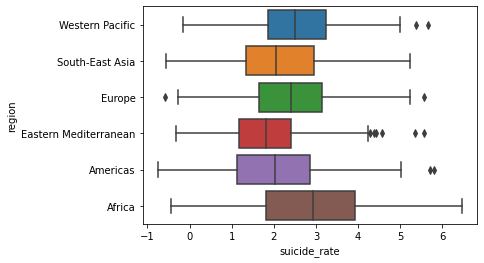

In [94]:
#Visualization of ln transformation distribution for assumption 3
sorted_boxplot(suicides_ln, region, suicide_rate)

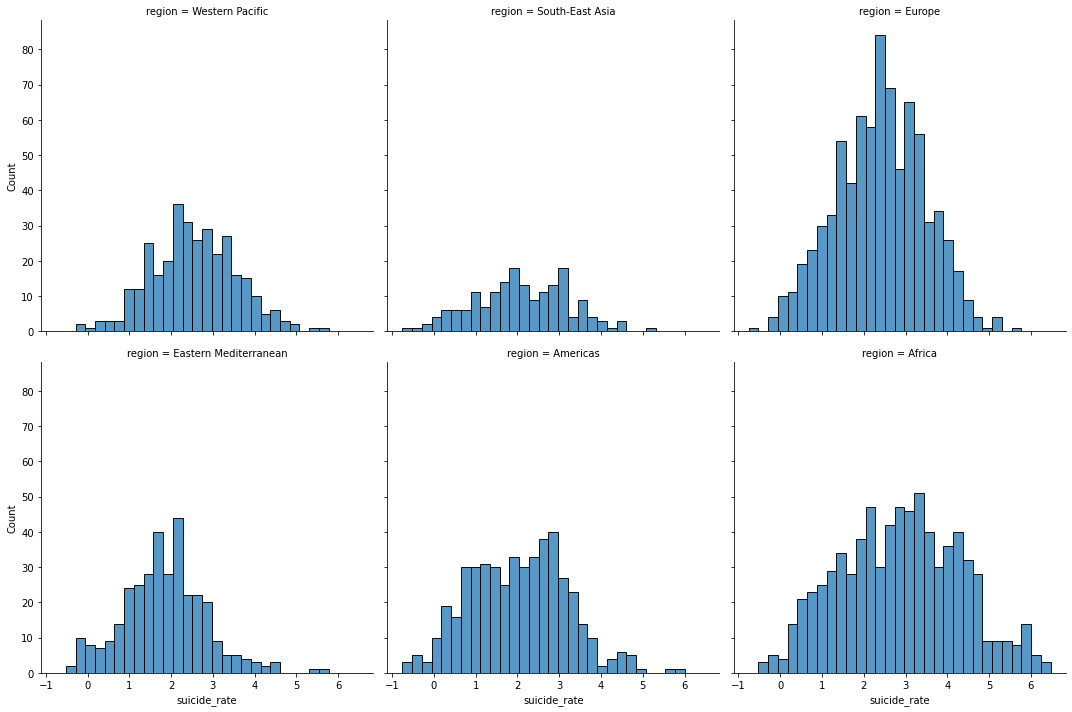

In [95]:
sns.displot(data=suicides_ln, x=suicide_rate, col=region, col_wrap=3)

Distribution for each region normalized compared to clean dataset<br>
Suicide Rates = e^Value

#### Suicide Rate by Age Range(ln)

In [96]:
#Calculating std of each age range to check if assumption 2 is met (std of groups should be equal)
column_std(suicides_ln, age_range, suicide_rate)

35-44 1.031310418926929
65-74 1.0966337880893082
45-54 1.0476237409418763
85PLUS 1.34389600374223
25-34 0.9924794295946476
15-24 0.9281282578965978
55-64 1.0888552278520494
75-84 1.143596054576989


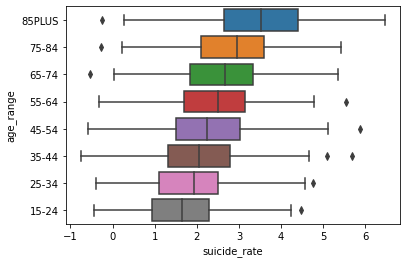

In [97]:
#Visualization of ln transformation distribution for assumption 3
sorted_boxplot(suicides_ln, age_range, suicide_rate)

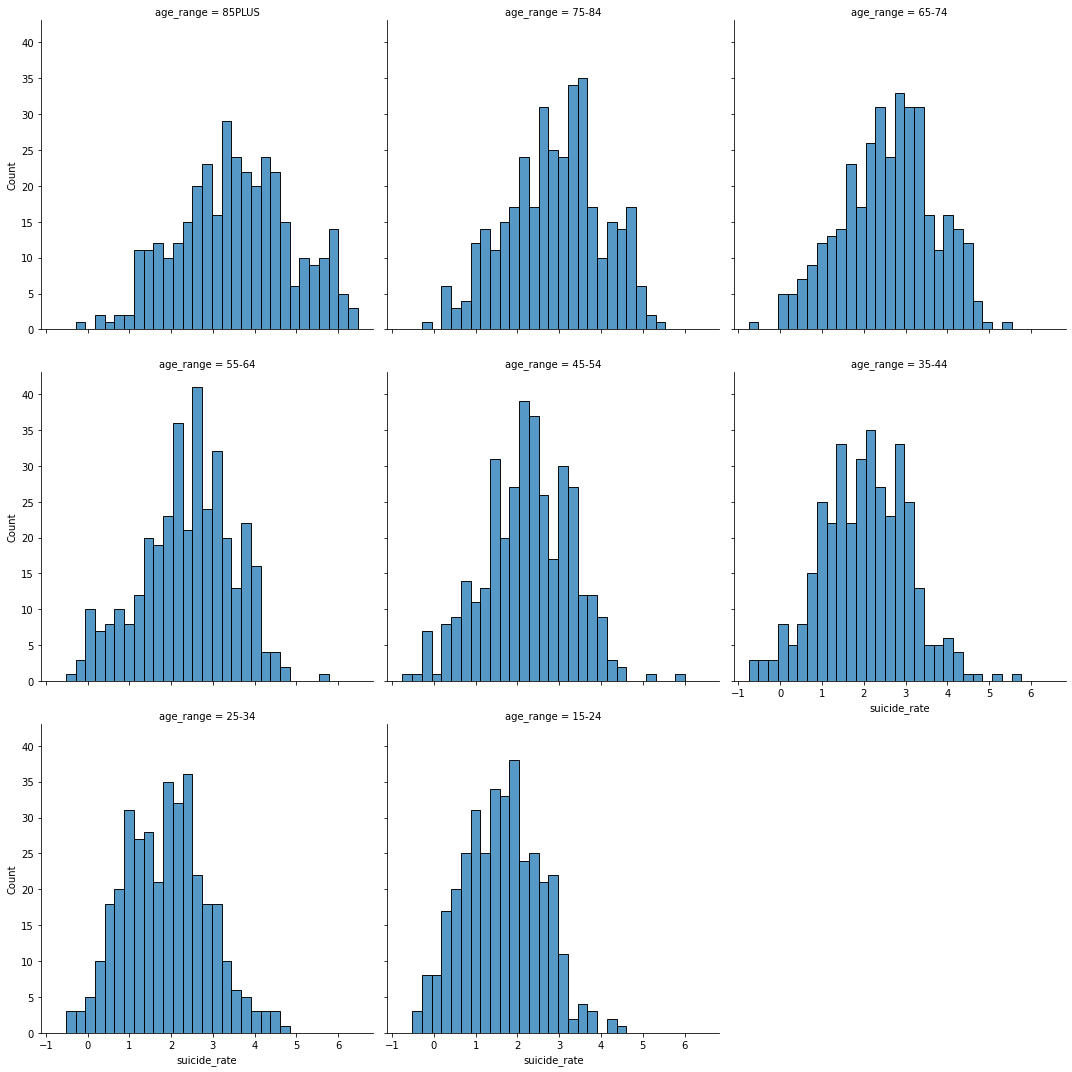

In [98]:
sns.displot(data=suicides_ln, x=suicide_rate, col=age_range, col_wrap=3)

Age range distributions are normalized<br>
Suicide Rates = e^Value

#### Suicide Rate by Sex(ln)

In [99]:
#Calculating std of each sex to check if assumption 2 is met (std of groups should be equal)
column_std(suicides_ln, sex, suicide_rate)

Male 1.0355875525978846
Female 1.0405803690308908


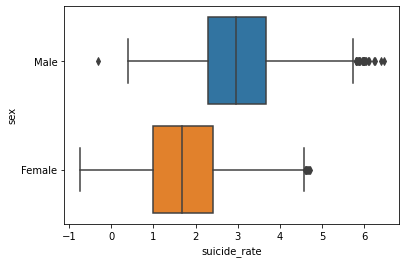

In [100]:
#Visualization of ln transformation distribution for assumption 3
sorted_boxplot(suicides_ln, sex, suicide_rate)

<AxesSubplot:xlabel='suicide_rate', ylabel='Count'>

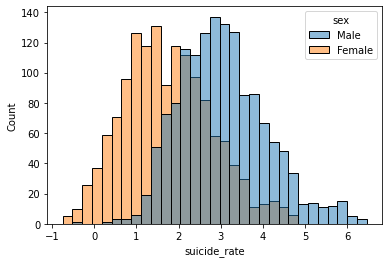

In [101]:
# Histogram to view overlap of suicide rates of males vs females
sns.histplot(data=suicides_ln, x=suicide_rate, hue=sex)

Slightly left skewed distributions<br>
Female distribution centered around Suicide Rates = e^1.5<br>
Male distribution centered around Suicide Rates = e^3

### Natural log transformation ANOVA Tests

#### ANOVA Test Suicide Rates by Region

In [102]:
#Anova test to determine if the pval is significant
anova_test(suicides_ln, region, suicide_rate)

1.1753090998849108e-52


In [103]:
#Tukey's Range Test to determine which pairings are significant
tukeys_test(suicides_ln, region, suicide_rate)

               Multiple Comparison of Means - Tukey HSD, FWER=0.05                
        group1                group2        meandiff p-adj   lower   upper  reject
----------------------------------------------------------------------------------
               Africa              Americas  -0.8569   -0.0 -1.0539 -0.6598   True
               Africa Eastern Mediterranean  -1.0334   -0.0 -1.2533 -0.8135   True
               Africa                Europe  -0.4773   -0.0 -0.6479 -0.3066   True
               Africa       South-East Asia    -0.78   -0.0 -1.0606 -0.4994   True
               Africa       Western Pacific   -0.335 0.0003  -0.557  -0.113   True
             Americas Eastern Mediterranean  -0.1766 0.2855 -0.4159  0.0628  False
             Americas                Europe   0.3796    0.0  0.1846  0.5746   True
             Americas       South-East Asia   0.0769 0.9768 -0.2192  0.3729  False
             Americas       Western Pacific   0.5219    0.0  0.2806  0.7631   True
East

##### Africa is significantly different from every other region<br>
Region pairs that are not significantly different are: (pval >= 0.05)<br>
Americas - Eastern Mediterranean<br>
Americas - South-East Asia<br>
Eastern Mediterranean - South-East Asia<br>
Europe - South-East Asia<br>
Europe - Western Pacific<br>
Natural Log transformation ANOVA test supports the results from the zscored normalized ANOVA test

#### ANOVA Test Suicide Rates by Age Range

In [104]:
#Anova test to determine if the pval is significant
anova_test(suicides_ln, age_range, suicide_rate)

2.0747091766665784e-143


In [105]:
#Tukey's Range Test to determine which pairings are significant
tukeys_test(suicides_ln, age_range, suicide_rate)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
 15-24  25-34   0.2531 0.0403  0.0059 0.5003   True
 15-24  35-44   0.4073    0.0  0.1601 0.6545   True
 15-24  45-54   0.6081    0.0  0.3611 0.8551   True
 15-24  55-64   0.7729   -0.0  0.5255 1.0202   True
 15-24  65-74   0.9674   -0.0  0.7201 1.2148   True
 15-24  75-84   1.2617   -0.0   1.014 1.5094   True
 15-24 85PLUS   1.9064   -0.0   1.658 2.1549   True
 25-34  35-44   0.1542 0.5556 -0.0928 0.4012  False
 25-34  45-54    0.355 0.0004  0.1081 0.6018   True
 25-34  55-64   0.5198    0.0  0.2726 0.7669   True
 25-34  65-74   0.7143   -0.0  0.4671 0.9615   True
 25-34  75-84   1.0086   -0.0   0.761 1.2561   True
 25-34 85PLUS   1.6533   -0.0  1.4051 1.9016   True
 35-44  45-54   0.2008 0.2099  -0.046 0.4476  False
 35-44  55-64   0.3656 0.0002  0.1184 0.6128   True
 35-44  65-74   0.5601    0.0   0.313 0.8073   True
 35-44  75-8

Age range pairs that are not significantly different are: (pval >= 0.05)<br>
25-34 - 35-44<br>
35-44 - 45-54<br>
45-54 - 55-64<br>
55-64 - 65-74<br>
A trend of age ranges that are close to each other appear to not be significantly different from each other except for 85PLUS<br>

#### Two Tail T-Test Suicide Rates by Sex

In [106]:
#2 Sample T test to determine if the pval is significant
two_tail_ttest(suicides_ln, sex, suicide_rate)

1.4175299532815954e-209


Pval <= 0.05 indicates we reject the null hypothesis<br>
The two suicide rates are not from the same population and have different means than the population